In [19]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import misc
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import pickle
%matplotlib inline

In [20]:
test_img_fnames = os.listdir('data/test')
train_img_fnames = os.listdir('data/train')

# Load in the data
First we need to write a function to load into memory each of the images, and then resize them to (224, 224, 3). scipy.misc.imread and scipy.misc.imresize will be useful for this. You should also rescale the images so that they are on a scale of 0 to 1, meaning each pixel value should be between 0 and 1. This can be achieved by dividing by an appropriate constant.

In [21]:
def load_img(filename):
    img = misc.imread(filename)
    img = misc.imresize(img, (224, 224))
    return img/255

In [22]:
test_imgs = [load_img(os.path.join('data/test', fname)) for fname in test_img_fnames]
test_imgs = np.stack(test_imgs)

In [23]:
train_imgs = []
for i in range(500):
    train_imgs.append(load_img(os.path.join('data/train', train_img_fnames[i])))
#train_imgs = [load_img(os.path.join('data/train', fname)) for fname in train_img_fnames]
train_imgs = np.stack(train_imgs)

In [24]:
with open('data/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

# Load Pretrained VGG network
Now in order to generate the CNN featurizations of our images we need to load a pretrained network. Note that running this network will take a long time on CPU so you can feel free to skip this section and just load the featurizations I provided in the next section

In [25]:
VGG16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [26]:
VGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
featurized_training_data = VGG16.predict(train_imgs, verbose=1)

 7936/10000 [======================>.......] - ETA: 51:10

In [ ]:
featurized_test_data = VGG16.predict(test_imgs, verbose=1)

In [ ]:
# Save featurizations
import pickle
with open('featurized_train_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_training_data, f)
with open('featurized_test_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_test_data, f)

# Load featurizations

In [27]:
import pickle
with open('featurized_train_imgs.pkl', 'rb') as f:
    featurized_training_data = pickle.load(f)
with open('featurized_test_imgs.pkl', 'rb') as f:
    featurized_test_data = pickle.load(f)

# Create your network
Now we need to create a network to take in the featurizations and output a label of dog or not dog. To do this you should use Keras' Sequential model. We will need to flatten our (7,7,512) feature input into a vector (HINT: lookup flatten in keras documentation) and then add a Dense layer with some number of neurons (play around with the number of neurons to improve your performance). Then finally we need a Dense layer with 1 neuron and a sigmoid activation to represent our label output. You might want to use more or less model.add calls than have been provided

In [28]:
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(7, 7, 512)))
model.add(Activation('relu'))


model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (1, 1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(1, 1)))



model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 3, 3, 32)          409632    
_________________________________________________________________
activation_4 (Activation)    (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 32)          9248      
_________________________________________________________________
activation_5 (Activation)    (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 32)          1056      
_________________________________________________________________
activation_6 (Activation)    (None, 1, 1, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0         
__________

# Now we need to train the network
You need to compile the model first, and then use the fit function. You should use binary crossentropy as your loss.

In [30]:
model.compile(optimizer='SGD', loss='binary_crossentropy')

In [31]:
model.fit(featurized_training_data, train_labels, epochs = 30)

ValueError: Input arrays should have the same number of samples as target arrays. Found 500 input samples and 10000 target samples.

Now we need to predict labels for the test set and output it to file. Use keras predict for this. Remember that the predictions are real values between 0 and 1 and you should be outputting just 0 or 1, not a value between.

In [18]:
predictions = model.predict(featurized_test_data, verbose=1)

2304/2500 [==========================>...] - ETA: 0s

In [203]:
with open('test_labels.txt', 'w') as f:
    f.write("Id,Label\n")
    for i, val in enumerate(predictions):
        prediction = int(np.round(val))
        f.write(str(i))
        f.write(',')
        f.write(str(prediction))
        f.write('\n')

# Part 2

In [16]:
from sklearn.decomposition import PCA

Now we want to run PCA on our images and our featurizations to see the difference. To save time we will just run it on the first 500 images. Take the first 500 images and 500 featurizations and reshape them into shape (500, x).

In [69]:
original_imgs = np.reshape(train_imgs[:500], (500,150528))
featurized = np.reshape(featurized_training_data[:500], (500,25088))

Run PCA with 2 components on the original images

In [51]:
pca_orig = PCA(n_components = 2)
pca_orig.fit(original_imgs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Run PCA with 2 components on the featurizations

In [52]:
pca_featurized = PCA(n_components = 2)
pca_featurized.fit(featurized)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Project the original images and featurizations onto the 2 principal components. (HINT: look at the PCA.transform function)

In [53]:
projected_orig_imgs = pca_orig.transform(original_imgs)
projected_featurized = pca_featurized.transform(featurized)

Find the indices of the labels that are cats and the indices that are dogs. np.where will make this very easy

In [64]:
labels = train_labels[:500]
cat_inds = np.where(labels == 0)
dog_inds = np.where(labels == 1)

Plot the PCA of the original images and the PCA of the featurization

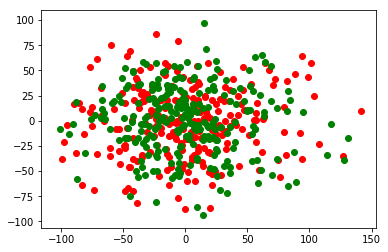

In [65]:
plt.scatter(projected_orig_imgs[cat_inds ,0], projected_orig_imgs[cat_inds, 1], c='red')
plt.scatter(projected_orig_imgs[dog_inds, 0], projected_orig_imgs[dog_inds, 1], c='green')

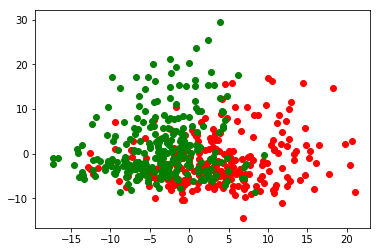

In [66]:
plt.scatter(projected_featurized[cat_inds ,0], projected_featurized[cat_inds, 1], c='red')
plt.scatter(projected_featurized[dog_inds, 0], projected_featurized[dog_inds, 1], c='green')

Question #1: Describe the differences you see between the two plots in terms of the clustering of the classes?

In the first plot, the classes are clustered very closely together, whereas in the second plot, the clusters are more spaced out than the first and fairly distinguishable. The second plot is a byproduct of featurizing the data before training with a CNN.

Question #2: Based on your answer to question 1, describe why it is useful to featurize with a CNN before training a fully connected model to classify the images.

It is useful to featurize with a CNN because it helps the model determine what features are significant in recognizing what is a cat or dog. This plot, unlike the previous one, captures certain characteristics that cats and dogs have as shown by the more distinct cat and dog clusters. Featurizing before training helps build patterns and shape features into more abstract features like having whiskers or dog type ears etc, the model can eventually tell through featurization which features correspond to cats and dogs, while simple training will be clueless as to what features its supposed to look for.